# Cats vs Dogs Classification

#### This is my implementation on the popular Kaggle "Cats vs Dogs" challenge. The plan is to use transfer learning for this problem. Since the PC is pretty old (GeForce 960, Intel i5 5600, 8GB DDR4) I decided to use MobileNet V2 for this task. I expected the training to be relatively fast with this model but I still had to leave it running a few hours for each test. The end result was surprisingly good to me - 98.1% accuracy. I was wondering what could be the result with Inception Resnet v2 and I achieved about 98.6% accuracy without any tweaking of parameters or intermediate layer unfreezing. 

In [1]:
import os
import time
import numpy as np
import tensorflow as tf
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, decode_predictions, preprocess_input
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Input, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.metrics import binary_accuracy
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img, load_img
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau

### Preprocessing

#### Before I start I resized the images to the MobileNet required size (224, 224) pixels. This way I save a lot of time on batch loading. My PC allows only 4 image batch sizes.

In [2]:
source = os.path.join(os.getcwd(), "train")
# os.mkdir("small_images")
dataset_dir = os.path.join(os.getcwd(), 'small_images')
cats_dir = os.path.join(dataset_dir, 'cats')
dogs_dir = os.path.join(dataset_dir, 'dogs')

# for pic in os.listdir(source):
#     img = os.path.join(source, pic)
#     img = Image.open(img)
#     img = img.resize([224, 224], Image.ANTIALIAS)
#     img.save(os.path.join(dataset_dir, pic), format="JPEG")

#### Here I'm getting the filenames from the cats and dogs subdirectories. After that It's easy to get the labels. I'm using "0" for cats and "1" for dogs

In [3]:
files = [file for dirname, subdir, file in os.walk(dataset_dir)]
files = files[1:]

filenames = []
for f in files[0]:
    filenames.append(os.path.join(cats_dir, f))
for f in files[1]:
    filenames.append(os.path.join(dogs_dir, f))
    
labels = [name.split(".")[-3][-3:] for name in filenames]
labels = [tf.constant(0) if label == "cat" else tf.constant(1) for label in labels]

#### Here I'm shuffling the data using pandas because it's very fast and easy. Shuffling using tf.data.Dataset on such a large dataset was very slow and I found this solution much better. After that I'm manually splitting the data to training, validation and test sets (23000 / 1000 / 1000). Since the I have such a large dataset I can test on more images and thus have the chance to predict some very hard pictures as we'll see in the end.

In [4]:
df = pd.DataFrame({"filenames": filenames, "labels": labels})
df = df.sample(frac=1, random_state=0).reset_index(drop=True)
shuffled_fnames = [path for path in df.filenames]
shuffled_labels = [label for label in df.labels]

train_filenames, val_filenames, test_filenames = shuffled_fnames[:23000], shuffled_fnames[23000:24000], shuffled_fnames[24000:]
train_labels, val_labels, test_labels = shuffled_labels[:23000], shuffled_labels[23000:24000], shuffled_labels[24000:]

In [5]:
def map_function(filename, label):
    img = tf.io.read_file(filename)
    img = tf.image.decode_image(img)
    img /= 255
    return (img, label)

In [6]:
BATCH_SIZE = 4

train_dataset = tf.data.Dataset.from_tensor_slices((train_filenames, train_labels))
train_dataset = train_dataset.map(map_function)
train_dataset = train_dataset.batch(4)
train_dataset = train_dataset.repeat()

val_dataset = tf.data.Dataset.from_tensor_slices((val_filenames, val_labels))
val_dataset = val_dataset.map(map_function)
val_dataset = val_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.repeat()

test_dataset = tf.data.Dataset.from_tensor_slices((test_filenames, test_labels))
test_dataset = test_dataset.map(map_function)
test_dataset = test_dataset.batch(BATCH_SIZE)

#### Loading MobileNetV2 body for transfer learning and freezing all layers. I'm doing this to manually add my dense layers for the binary classification and to train only the dense layers parameters using the pre-trained convolution layers as feature extractors.

In [12]:
mnet = MobileNetV2(include_top=False, input_shape=(224, 224, 3))
for layer in mnet.layers:
    layer.trainable = False

In [13]:
model = Sequential([
    mnet,
    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(lr=1e-5), loss='binary_crossentropy', metrics=['binary_accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
flatten (Flatten)            (None, 62720)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               8028288   
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 10,286,913
Trainable params: 8,028,673
Non-trainable params: 2,258,240
_____________________________________

In [14]:
log_dir = os.path.join(os.getcwd(), 'logs')
checkpoint_dir = os.path.join(os.getcwd(), 'chpt{epoch}')
checkpoint = ModelCheckpoint(checkpoint_dir, save_best_only=True)
tensorboard = TensorBoard(log_dir=log_dir)
learn_rate = ReduceLROnPlateau(factor=0.2, patience=3, min_lr=1e-6, cooldown=20, verbose=1)

In [ ]:
start = time.localtime()

history = model.fit_generator(train_dataset, 
                    steps_per_epoch=len(train_filenames)//BATCH_SIZE, 
                    epochs=25, 
                    validation_data=val_dataset, 
                    validation_steps=len(val_filenames)//BATCH_SIZE,
                    callbacks=[tensorboard, learn_rate, checkpoint]
                    )

end = time.localtime()
total_minutes = end.tm_min - start.tm_min

In [ ]:
print(end)
print(start)
print(f"Total time elapsed: {end.tm_hour - start.tm_hour}:{abs(end.tm_min - start.tm_min)}")

In [ ]:
model.save('cats_dogs_transfer_mobilenet_dataset.h5')

In [ ]:
# loaded_model = load_model(checkpoint_dir)

In [ ]:
loaded_model = load_model('cats_dogs_transfer_mobilenet_dataset.h5')

### Evaluating the trained model

In [ ]:
loaded_model.evaluate_generator(test_dataset)

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

#### The graph shows that epoch 8 was the optimal one for stop training. I didn't have a checkpoint there and the moment was skipped, but since I plan to fine-tune the model this should be corected. In the future I'd use checkpoint save on every epoch if 1 epoch takes 30 min.

In [ ]:
prediction = loaded_model.predict_generator(test_dataset, verbose=1)

In [ ]:
prediction.shape

### Testing on a chosen set of 10 pictures. 

In [ ]:
# the test dir has 1000 images
from_index = 990 
to_index = 1000
for i in range(from_index, to_index):
    path = test_filenames[i]
    img = load_img(path)
    plt.imshow(img)
    img = map_function(test_filenames[i], test_labels[i])[0]
    img = np.expand_dims(img, 0)
    pred = loaded_model.predict(img)
    if pred > 0.5:
        result = "dog"
    else:
        result = "cat"
    plt.title(f'prediction: {result}')
    plt.show()

### Now I'm unfreezing 8 more layers for additional training. The goal is to have the last convolutional layers extract smaller features and thus fine-tune the model

In [ ]:
for layer in loaded_model.layers[0].layers[-8:]:
    layer.trainable = True

In [ ]:
new_model = loaded_model

In [ ]:
new_model.compile(optimizer=Adam(lr=1e-5), loss='binary_crossentropy', metrics=['binary_accuracy'])

In [ ]:
new_model.summary()

In [ ]:
start = time.localtime()

history1 = new_model.fit_generator(train_dataset, 
                    steps_per_epoch=len(train_filenames)//BATCH_SIZE, 
                    epochs=8, 
                    validation_data=val_dataset, 
                    validation_steps=len(val_filenames)//BATCH_SIZE,
                    callbacks=[tensorboard, learn_rate, checkpoint]
                    )

end = time.localtime()

In [ ]:
new_model.evaluate_generator(test_dataset)

In [ ]:
new_model.save('cats_dogs_transfer_mobilenet_dataset_finetuned.h5')

In [ ]:
new_model = load_model('cats_dogs_transfer_mobilenet_dataset_finetuned.h5')

#### This was a middle step to and now I'm unfreezing all layers to fine-tune the model for the last time. It's a bit slower because we have about 700k more parameters.

In [ ]:
new_model.layers[0].trainable = True

In [ ]:
fine_tuned_model = new_model
fine_tuned_model.summary()

In [ ]:
fine_tuned_model.compile(optimizer=Adam(lr=1e-5), loss='binary_crossentropy', metrics=['binary_accuracy'])
checkpoint_dir = os.path.join(os.getcwd(), 'checkpoint-{epoch:02d}-{val_loss:.4f}.hdf5'
checkpoint = ModelCheckpoint(checkpoint_dir, verbose=1)

In [ ]:
start2 = time.time()

history2 = fine_tuned_model.fit_generator(train_dataset, 
                    steps_per_epoch=len(train_filenames)//BATCH_SIZE, 
                    epochs=10, 
                    validation_data=val_dataset, 
                    validation_steps=len(val_filenames)//BATCH_SIZE,
                    callbacks=[tensorboard, checkpoint, learn_rate]
                    )

end2 = time.time()

In [ ]:
print(f"Total time elapsed: {end2 - start2} sec.")

In [ ]:
fine_tuned_model.save('cats_dogs_transfer_mobilenet_dataset_finetuned.h5')

In [15]:
fine_tuned_model = load_model('cats_dogs_transfer_mobilenet_dataset_finetuned.h5')

In [ ]:
fine_tuned_model.save_weights('./checkpoint/my_checkpoint')

In [16]:
model.load_weights('./checkpoint/my_checkpoint')
fine_tuned_model = model

In [17]:
fine_tuned_model.evaluate_generator(test_dataset)

[0.06740164769489775, 0.981]

#### Now comes the most interesting part. I'm testing the model on the 1000 images test dataset and after that I'm plotting the wrong predictions. This way we can visually try to find out why the model was wrong. It turns out the "hard" pictures have a lot of objects, the animal is partially visible, or the quality is very bad. I can safely say that if the picture is relatively good and the object is not partially hidden we can be confidet that the prediction will be correct.

In [16]:
# the test dir has 1000 images
wrong_preds = []
for i in range(1000):
    img, label = map_function(test_filenames[i], test_labels[i])
    img = np.expand_dims(img, 0)
    pred = fine_tuned_model.predict(img)
    if pred >= 0.5:
        result = 1
    else:
        result = 0
#     plt.title(f'prediction: {result}')
#     plt.show()
    if result != int(label.numpy()):
        wrong_preds.append(test_filenames[i])


In [17]:
len(wrong_preds)

19

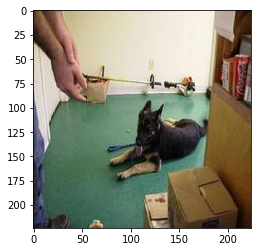

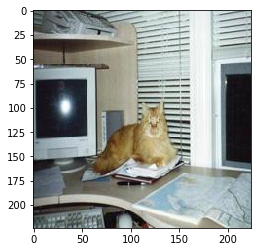

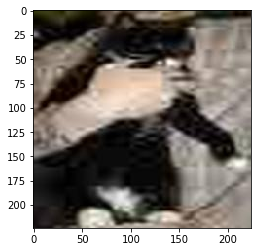

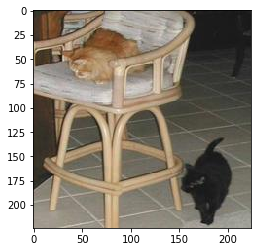

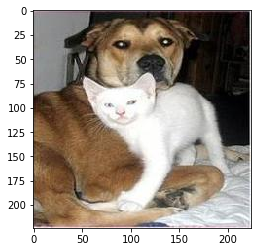

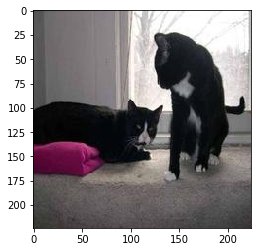

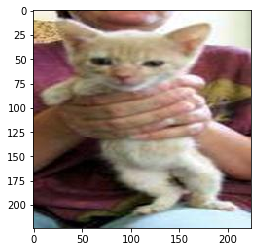

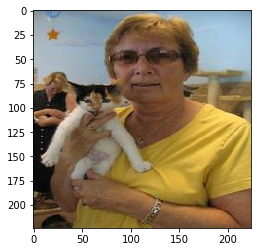

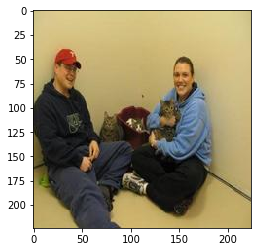

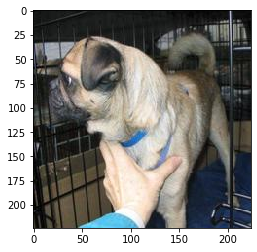

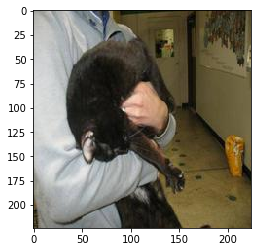

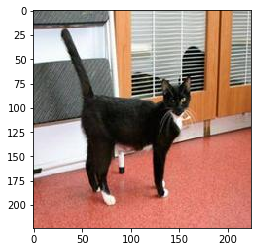

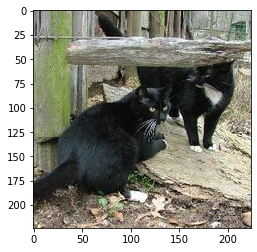

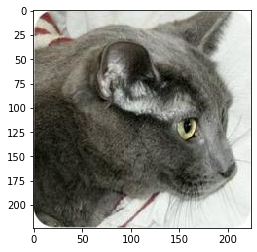

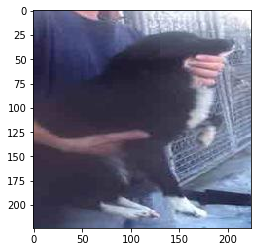

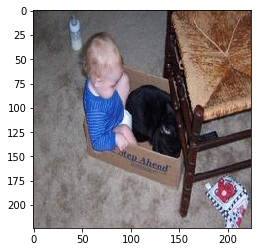

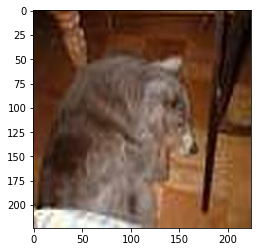

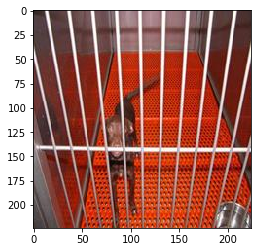

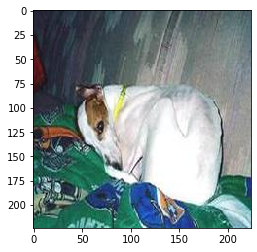

In [18]:
for i in wrong_preds:
    plt.figure()
    path = i
    pic = load_img(path)
    plt.imshow(pic)

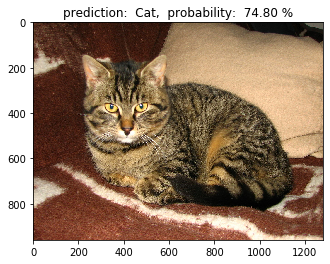

In [19]:
# Testing on a different image placed in the current working directory
name = 'cat.jpg'
img = tf.io.read_file(os.path.join(os.getcwd(), name))
img = tf.image.decode_jpeg(img, channels=3)
plt.imshow(img)
img = tf.cast(img, tf.float32)
img = tf.image.resize(img, [224, 224])
img = np.expand_dims(img, 0)
pred = fine_tuned_model.predict(img)
if pred > 0.5:
    result = "Dog"
else:
    result = "Cat"
plt.title(f'prediction:  {result},  probability:  {(100-pred[0][0]*100):.2f} %')
plt.show()

### Conclusion

#### MobileNet is a great model in terms of performance and results. It can be used in video applications where a few % accuracy can be sacrificed for the great performance. 
#### There is little more that can be done to increase the accuracy. I tried to augument the pictures but the dataset is so large that I didn't notice any difference. I could probably adjust the dropout and add L1/L2 regularizers but I felt like I have reached optimal results without this. After all If I need higher accuracy I can switch to Inception Resnet but I decided to learn how to solve new deep learning problems than to waste time in training. 